# Evaluate results of experiment

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import re

pd.options.display.max_columns = 999

In [94]:
output_folder = pathlib.Path('output')
sns.set_context("paper")

In [95]:
def prepare(df):
    df['type'] = ['log-model','log-md','md-m']
    df['Precision'] = df['logModel_largestEigenValue'] / df['model_largestEigenValue']
    df['Recall'] = df['logModel_largestEigenValue'] / df['log_largestEigenValue']
    return df

# Collect results

In [96]:
dfs = []

for f_out in output_folder.glob('[0-9]*'):
    # print(f_out)
    run_id = re.findall(r'[0-9]+', f_out.name)[0]
    run_folder = output_folder / run_id
    for f_out_file in run_folder.glob('*.csv'):
        try:
            n = int(re.findall(r'[0-9]+', f_out_file.name)[0])
            # print(f_out, n)
            df = pd.read_csv(f_out_file, sep=';')
            df = prepare(df)
            df['logSize'] = n
            df['run_id'] = int(run_id)
            dfs.append(df)
        except:
            pass
df = pd.concat(dfs)

In [97]:
df.head()

,model_name,model_timeMillis,model_timeDeterminization,model_timeMinimization,model_timeEigen,model_netSize,model_automatonSizeOrig,model_automatonSizeDeterministic,model_automatonSize,model_entropy,model_largestEigenValue,model_entropyComputationConverged,model_convergenceThreshold,logModel_name,logModel_timeMillis,logModel_timeDeterminization,logModel_timeMinimization,logModel_timeEigen,logModel_netSize,logModel_automatonSizeOrig,logModel_automatonSizeDeterministic,logModel_automatonSize,logModel_entropy,logModel_largestEigenValue,logModel_entropyComputationConverged,logModel_convergenceThreshold,log_name,log_timeMillis,log_timeDeterminization,log_timeMinimization,log_timeEigen,log_netSize,log_automatonSizeOrig,log_automatonSizeDeterministic,log_automatonSize,log_entropy,log_largestEigenValue,log_entropyComputationConverged,log_convergenceThreshold,type,Precision,Recall,logSize,run_id
0,M,0,0,0,3,34,38,38,38,0.790988,1.730259,True,1.000000e-07,L,0,0,1,3,10000,38,38,38,0.790988,1.730259,True,1.000000e-07,L,0,0,1,3,10000,38,38,38,0.790988,1.730259,True,1.000000e-07,log-model,1.000000,1.0,10000,1
1,b60ad0d2-ba96-4a1c-8397-cab01c9f88a7,0,1,0,3,34,38,38,38,0.790988,1.730259,True,1.000000e-07,L,0,0,1,2,10000,38,38,38,0.790988,1.730259,True,1.000000e-07,L,0,0,1,2,10000,38,38,38,0.790988,1.730259,True,1.000000e-07,log-md,1.000000,1.0,10000,1
2,Md,0,0,1,4,38,38,38,38,0.790988,1.730259,True,1.000000e-07,MdM,0,0,1,4,38,38,38,38,0.790988,1.730259,True,1.000000e-07,b60ad0d2-ba96-4a1c-8397-cab01c9f88a7,0,0,0,3,38,38,38,38,0.790988,1.730259,True,1.000000e-07,md-m,1.000000,1.0,10000,1
0,M,0,0,0,14,34,38,38,38,0.790988,1.730259,True,1.000000e-07,L,0,0,1,9,10,43,43,43,0.276827,1.211528,True,1.000000e-07,L,0,0,1,9,10,43,43,43,0.276827,1.211528,True,1.000000e-07,log-model,0.700200,1.0,10,1
1,3f512973-9c0a-4e57-acf4-c1eb3d0bc80f,0,0,1,131,41,46,46,46,0.854174,1.807724,True,1.500000e-07,L,0,0,1,8,10,43,43,43,0.276827,1.211528,True,1.000000e-07,L,0,0,1,8,10,43,43,43,0.276827,1.211528,True,1.000000e-07,log-md,0.670195,1.0,10,1


# Precision
We analyze precision of:
* the simulated log vs. the model
* the simulated log vs. the discovered model
* the discovered model vs. the model

In [98]:
img_out_folder = pathlib.Path('evaluation')
img_out_folder.mkdir(exist_ok=True)

In [99]:
def plot_lines(df, run_id, y_type='Precision'):
    f, ax = plt.subplots(figsize=(10, 7))
    ax.set(xscale="log")
    ax.set_title("Experiment run "+str(run_id))
    
    sns_plot = sns.lineplot(x='logSize',y=y_type, style='type', hue='type',data=df,).get_figure()
    ax.set_ylim(-0.03,1.03)
    img_name = str(img_out_folder / str(str(run_id) + "_" + y_type+".png"))
    sns_plot.savefig(img_name)
        
    return sns_plot

In [100]:
runs = sorted(df['run_id'].drop_duplicates().values)
runs

[0, 1, 2, 3, 4]

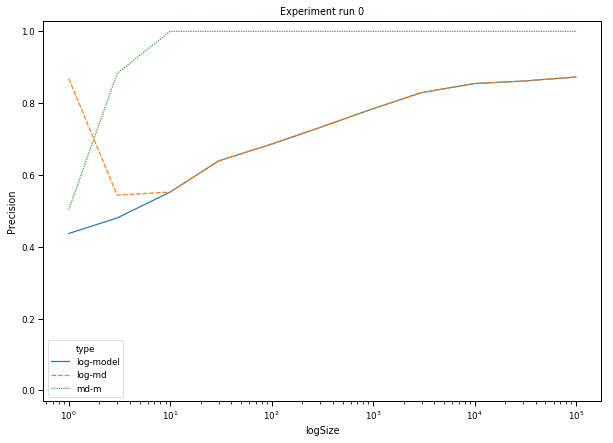

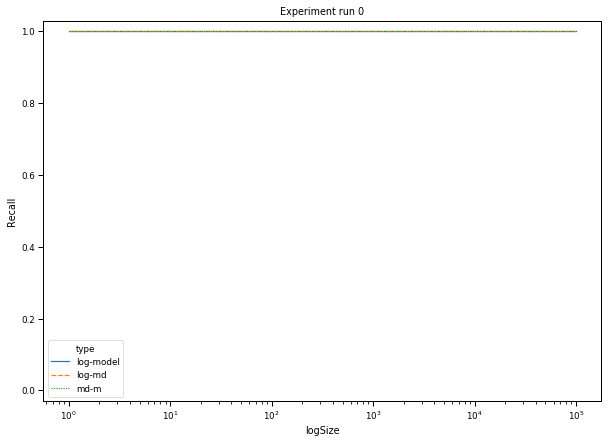

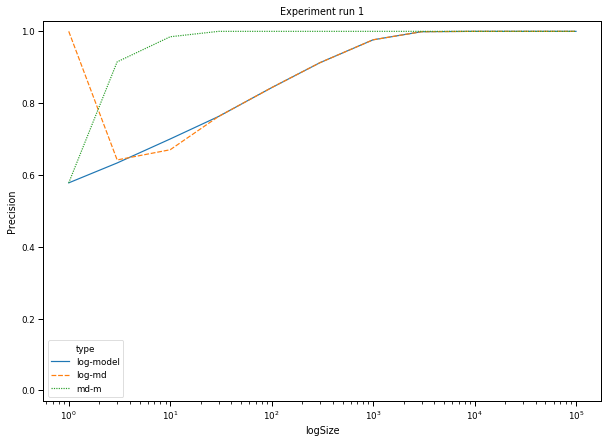

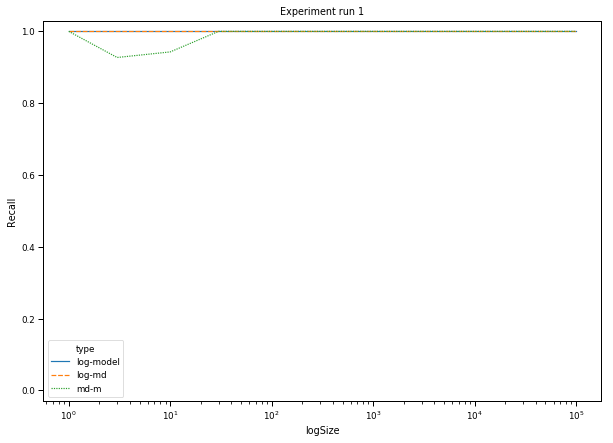

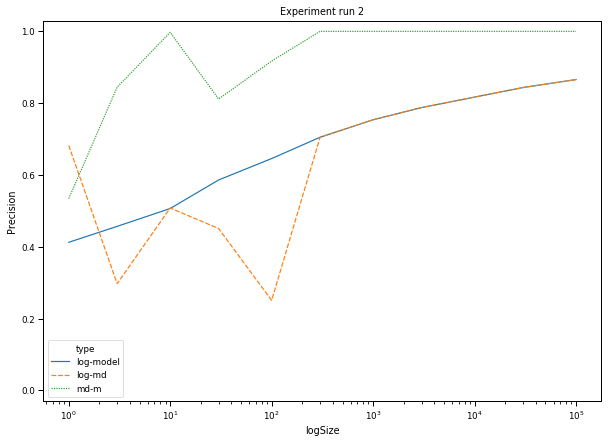

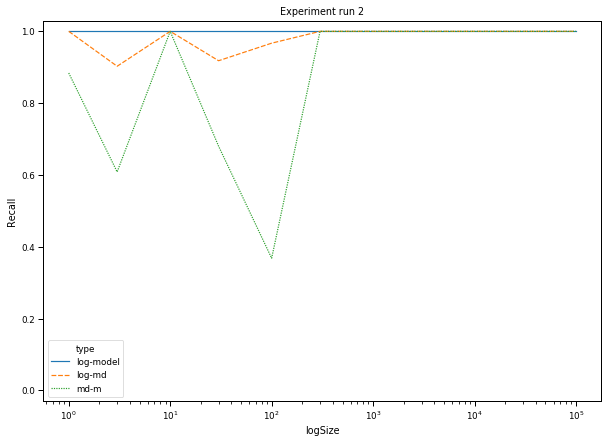

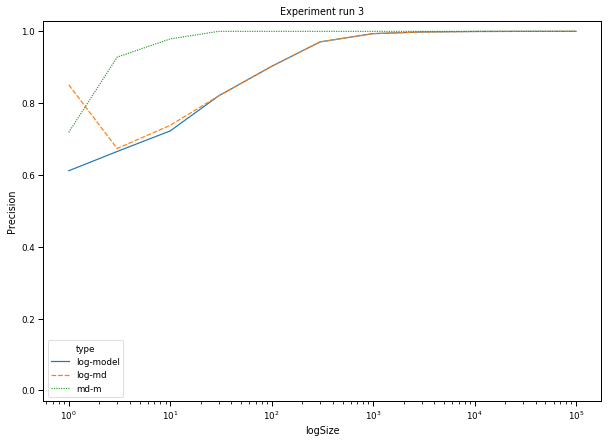

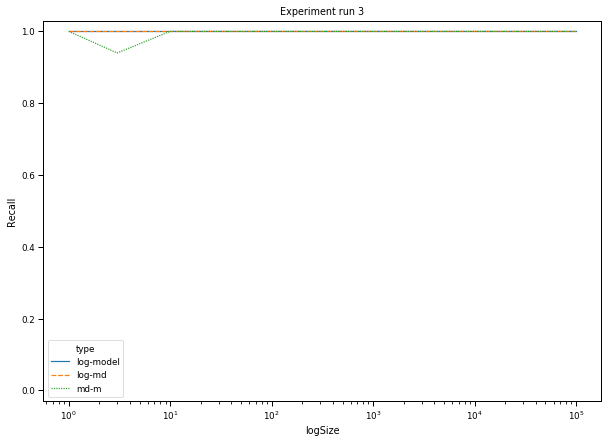

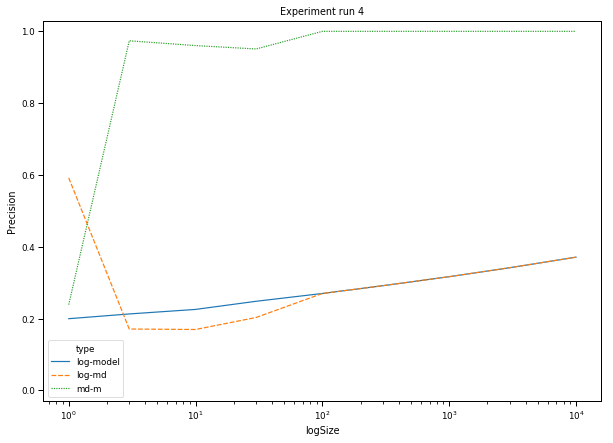

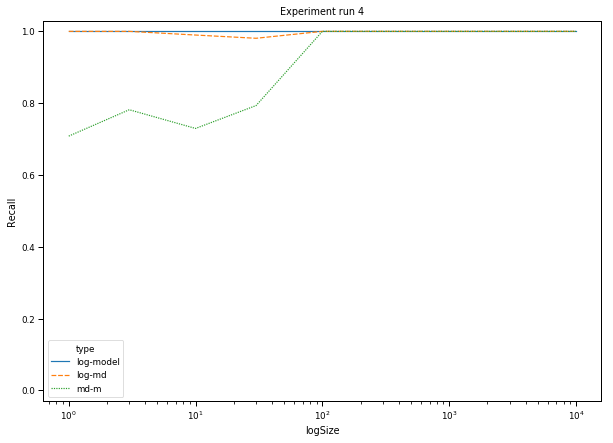

In [101]:
for run_id in runs:
    plot_lines(df.loc[lambda x: x['run_id']==run_id], run_id)
    plot_lines(df.loc[lambda x: x['run_id']==run_id], run_id, y_type='Recall')

# Interpretation:

## Precision graphs:
* The green curve "md-m" shows how the discovered model $M_d$ gets closer to the real model $M$. At logsize 10, the discovered model is the same as the original model $M$. Before that, the discovered model does not fully cover the possibilities allowed in the model.
* The blue curve "log-model": The log $L'_i$ gets more and more precise, as it contains gradually more and more variants of the model $M$.
* The orange curve "log-md": shows the precision of the log $L'_i$ vs the discovered model $M_d$, as $i$ increases. This depends on the generalization of the miner. In case the discovered model for a single trace contains a loop as a generalization, we see that the precision is not necessarily 1 for a log size of 1.

## Recall graphs:
* Because we did not insert noise into the log, the recall is always 1 between log/model.
* the recall between log and discovered model (log-md) can be lower than one, because:
  * the discovered models partly cannot replay some parts in the log (this is the case, if the discovery method does not guarantee full fitness)
  * or, there might be some numerical instability in the computation of the eigenvalues
* the recall between discovered model and model (md-m) can be lower than 1, if the discovered model allows behaviour not allowed in the original model (if it generalizes too much)

In [55]:
df['Recall'].min(), df['Recall'].max()

(0.3681059046164348, 1.0000000000012377)